In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from shap_explainer import ShapKernelExplainer
import shap
import pandas as pd
import numpy as np
import plotly
np.random.seed(0)
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('wine_quality/winequality-red.csv')
df['quality'] = df['quality'].astype(int)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<Axes: >

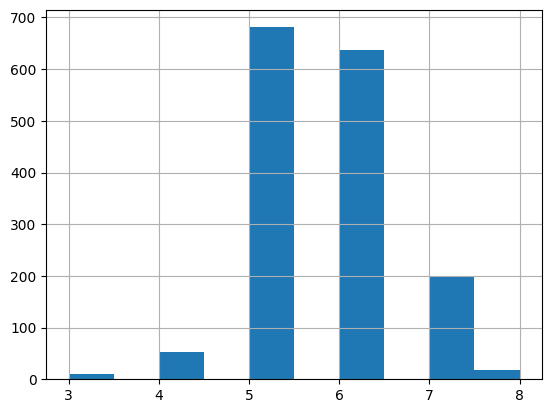

In [5]:
df['quality'].hist()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

Y = df['quality']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [9]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

In [22]:
explainer =  ShapKernelExplainer(model, shap.kmeans(X_train, 10))
shap_values = explainer.explain(X_train.iloc[:250])

  0%|          | 0/250 [00:00<?, ?it/s]

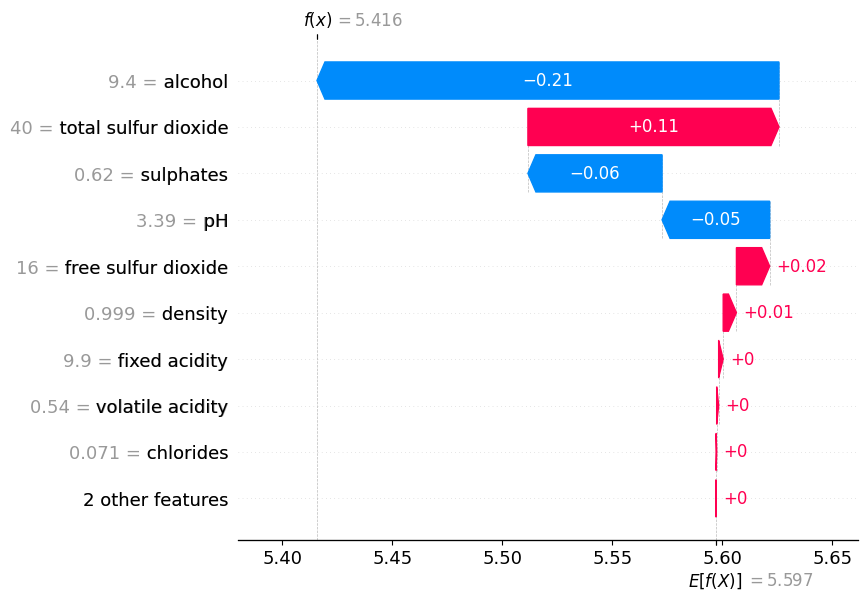

In [25]:
explainer.waterfall(shap_values[0])

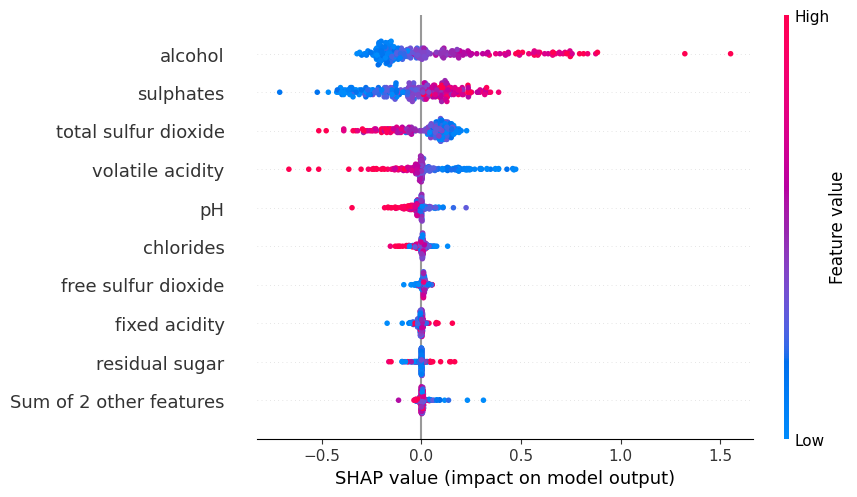

In [26]:
explainer.beeswarm(shap_values)

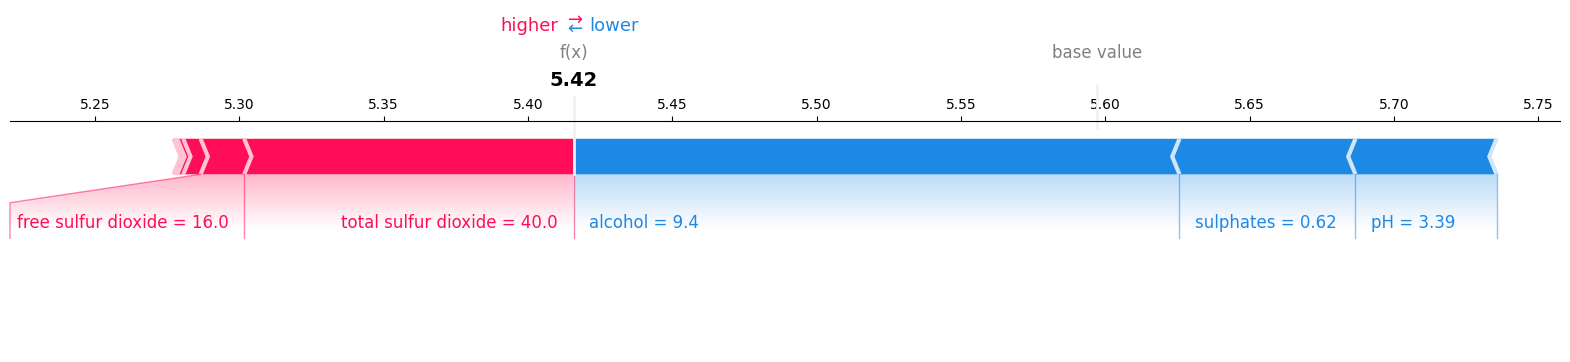

In [27]:
explainer.force(shap_values[0])

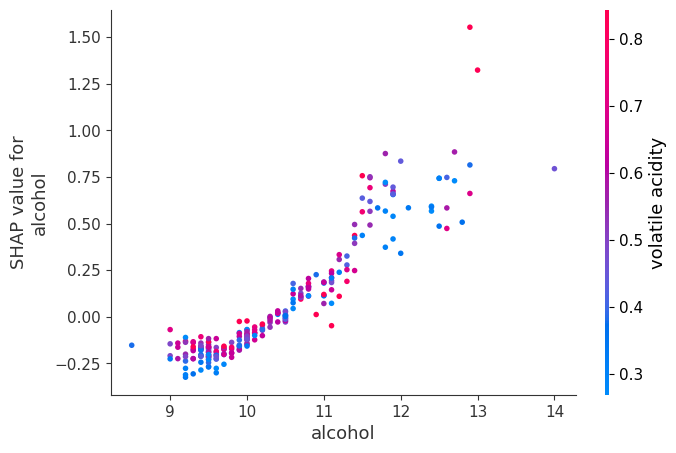

In [29]:
explainer.dependence_plot('alcohol', shap_values.values, X_train.iloc[:250], interaction_index='auto')

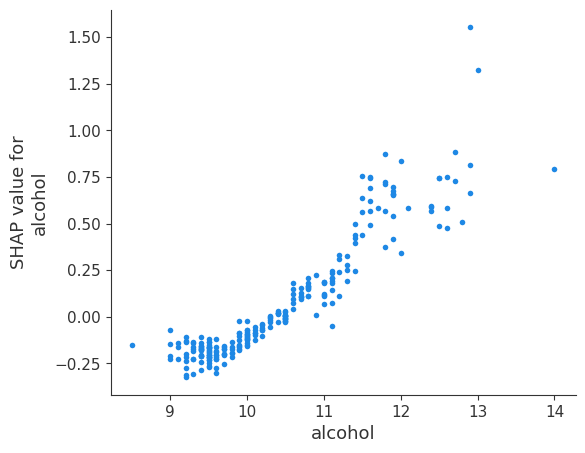

In [30]:
explainer.dependence_plot('alcohol', shap_values.values, X_train.iloc[:250])

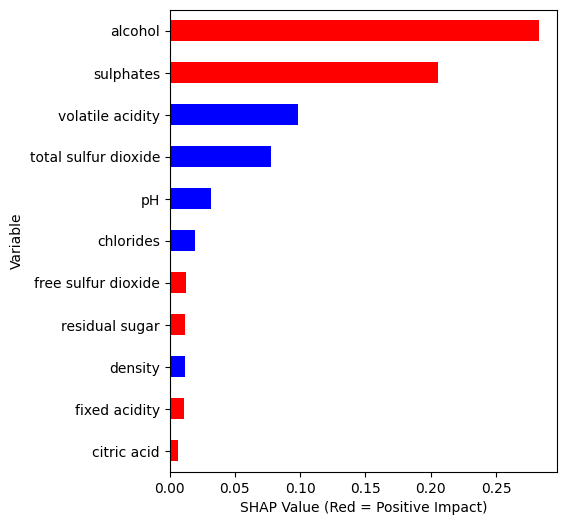

In [87]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
